In [9]:
%matplotlib ipympl
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter
from tqdm import tqdm
from scipy.signal import convolve2d
import pickle
import imageio.v2 as imageio

# Build of the Cellular Potts Model



Volume term:
- Type cell to shape relation to pressure


Initilizing:
- neighbors
- hexagon init
- 

In [ ]:
class CellularPottsModel:
    def __init__(self, 
                 n_cells:int=50, 
                 n_types: int=2, 
                 T: int=1, 
                 L:int=100,
                 C_v: int=1,
                 C_p: int=0,
                 adhessions=None, 
                 lattice_type: str="hex",
                 object_volumes: list[float]=None):
        
        self.L = L 
        self.n_cells = n_cells
        self.T = T
        self.C_v = C_v
        self.C_p = C_p
        self.n_types = n_types
        self.adhessions = adhessions  # list of adhessions(should be a flatten [n_typesxn_types] matrix)
        
        self.object_volumes = object_volumes  # None or a list of target volume for each cell
        
        if lattice_type is None:
            self.lattice = np.random.randint(0, self.n_cells, (self.L, self.L))
        elif lattice_type == "hex":
            self.lattice = self.init_hexlattice()
        else:
            raise ValueError("Either random or hex, or implement other shape init.")
        
        self.tau = self.set_cell_type()  # is dict of cells (keys) and the cell types
        self.J = self.set_adhesion_coefficient_J()
        self.V = self.set_object_volumes()  # is a dict of the cells (keys) and objective volumes
        self.P = self.set_object_perimeters()  # is a dict of the cells (keys) and objective perimeters
        self.volume_unit = 1

    #-------------------------------------------------------
    # SET UP FOR PRACTICALITIES, COEFFICIENTS AND TYPE/CELL BASED CONSTANTS: 
    #-------------------------------------------------------

    def neighbors_2d(self, point_index):
        """
        Returns a list of the neighbors (periodic boundaries) for element (i, j).
        """
        i, j = point_index
        neighbors = [
                    ((i - 1) % self.L, (j - 1) % self.L), 
                    ((i - 1) % self.L, j),
                    ((i - 1) % self.L, (j + 1) % self.L),
                    (i, (j - 1) % self.L),
                    (i, (j + 1) % self.L),
                    ((i + 1) % self.L, (j - 1) % self.L),
                    ((i + 1) % self.L, j),
                    ((i + 1) % self.L, (j + 1) % self.L),
                    ]
        return neighbors
    
    def init_hexlattice(self):
        """
        Function that will init a grid with hexagons (more voronoi-ish actually)
        """
        # Estimate hex spacing
        spacing = int(np.sqrt(self.L*self.L / self.n_cells))

        # Generate hex-grid of candidate centers
        centers = []
        for j in range(0, self.L, spacing):
            shift = (j // spacing) % 2 * (spacing // 2)
            for i in range(shift, self.L, spacing):
                centers.append((i, j))

        centers = np.array(centers)

        # If too many or too few, randomly select 50
        if len(centers) > self.n_cells:
            idx = np.random.choice(len(centers), self.n_cells, replace=False)
            centers = centers[idx]
        elif len(centers) < self.n_cells:
            # pad with random ones if too few
            extra = np.column_stack((
                np.random.randint(0, self.L, self.n_cells - len(centers)),
                np.random.randint(0, self.L, self.n_cells - len(centers))
            ))
            centers = np.vstack([centers, extra])

        yy, xx = np.mgrid[0:self.L, 0:self.L] # (L,L)
        coords = np.stack((xx, yy), axis=-1)  # (L,L,2)

        # Reshape for broadcasting:
        # coords → (L,L,1,2)
        # centers → (1,1,n_cells,2)
        coords_b = coords[:, :, None, :]              # add axis
        centers_b = centers[None, None, :, :]         # add axis
        d2 = np.sum((coords_b - centers_b)**2, axis=3)   

        lattice = np.argmin(d2, axis=2).astype(np.int32) + 1
        return lattice


    def set_cell_type(self):
        tau = {}  # cell type dict
        for i in range(self.n_cells):
            tau[i] = np.random.choice(self.n_types)
        return tau
        
    def set_object_volumes(self):
        V = {}  # volume dict
        if self.object_volumes is None:
            for i in range(self.n_cells): # for each cell identifier
                V[i] = ((self.L * self.L) / self.n_cells)
        elif self.V is not None:
            for i, vol in enumerate(self.object_volumes):
                V[i] = vol
        return V
    
        
    def set_object_perimeters(self):
        P = {}  # perimeter dict
        for i in range(self.n_cells): # for each cell identifier
            P[i] = 2*np.sqrt(np.pi*self.V[i])  # approximate perimeter from volume assuming circular shape
        return P

    def set_adhesion_coefficient_J(self):
        if self.adhessions is None:
            J = np.ones([self.n_types, self.n_types])
        else:
            J = self.adhessions.reshape(self.n_types, self.n_types) 
        return J

    #-------------------------------------------------------
    # HAMILTONIAN CALCULATION LOGIC
    #-------------------------------------------------------
    
    def adhesion_term(self, 
                      point_index, 
                      point_value, 
                      grid):
        """
        Calculate the adhession term.
        """
        neighbors = self.neighbors_2d(point_index)
        neighbor_values = np.array([grid[r, c] for r, c in neighbors])
        different_mask = (neighbor_values != point_value)  # The neighbors that are not the same as the point
        diffs = [self.J[self.tau.get(point_value), self.tau.get(nval)] 
                 for nval in neighbor_values[different_mask]] 
        H_adh = np.sum(diffs)
        return H_adh
    
    def volume_term(self, 
                    point_value, 
                    grid,
                    new: bool=None, 
                    source: bool=None):
        """
        Calculate the volume term.
        """
        if self.C_v == 0:
            return 0
        else:
            target_vol = self.V.get(point_value)
            if new and not source: # if we were to change the point, and the point we are looking at is the target point
                current_vol = np.sum(grid == point_value) - self.volume_unit
            elif new and source: # if we were to change the point, and the point we are looking at is the source point
                current_vol = np.sum(grid == point_value) + self.volume_unit
            else:
                current_vol = np.sum(grid == point_value)
            H_vol = (current_vol - target_vol)**2
            return H_vol
    
    def perimeter_term(self,
                       source_point_value,
                       target_point_value,
                       target_point_index,
                       grid, 
                       new: bool):
        """
        Calculate the perimeter term.
        """
        if self.C_p == 0:
            return 0
        else:
            kernel_8 = np.array([[1,1,1],
                     [1,0,1],
                     [1,1,1]], dtype=np.int32)
            
            def compute_perimeter_periodic(grid, value):
                """
                Compute perimeter of all pixels with a given value,
                using 8-connected neighbors and periodic boundaries.
                """
                mask = (grid == value).astype(np.int32)
                # Pad with wrap (periodic)
                mask_wrapped = np.pad(mask, pad_width=1, mode='wrap')
                # Convolve
                neighbor_count = convolve2d(mask_wrapped, kernel_8, mode='valid')
                
                # Each pixel contributes perimeter = #neighbors that are different
                perimeter_grid = 8 - neighbor_count
                return np.sum(perimeter_grid[mask == 1])
            

            grid_copy = grid.copy()
            if new: # Assume we are changing the target point to the source point
                grid_copy[target_point_index] = source_point_value
                
            P_source = compute_perimeter_periodic(grid_copy, source_point_value)
            P_target = compute_perimeter_periodic(grid_copy, target_point_value)
            
            H_perim = (P_source - self.P.get(source_point_value))**2 + (P_target - self.P.get(target_point_value))**2
            
            return H_perim

    def calculate_H(self,
                    source_point, target_point, 
                    target_point_index, grid, 
                    new: bool):
        """
        Calculate the the Hamiltonian (total energy).
        """
        if new: # Assume we are changing the target point to the source point  
            H = (
                self.adhesion_term(point_index=target_point_index, point_value=source_point, grid=grid) + 
                self.C_v *
                    (
                    self.volume_term(point_value=target_point, grid=grid, new=new, source=False) + 
                    self.volume_term(point_value=source_point, grid=grid, new=new, source=True)
                    ) +
                self.C_p *
                (
                    self.perimeter_term(source_point_value=source_point,
                                        target_point_value=target_point,
                                        target_point_index=target_point_index,
                                        grid=grid,
                                        new=new)
                )
                )
        else:
            H = (
                self.adhesion_term(point_index=target_point_index, point_value=target_point, grid=grid) + 
                self.C_v *
                    (
                    self.volume_term(point_value=target_point, grid=grid, new=new, source=False) + 
                    self.volume_term(point_value=source_point, grid=grid, new=new, source=True)
                    ) +
                self.C_p *
                    (
                    self.perimeter_term(source_point_value=source_point,
                                        target_point_value=target_point,
                                        target_point_index=target_point_index,
                                        grid=grid,
                                        new=new)
                    )
                )
        return H

    #---------------------------------------------------------
    # MONTE CARLO STEP AND ANIMATION LOGIC
    #---------------------------------------------------------

    def step(self, grid):
        source_point_index = [np.random.randint(self.L), np.random.randint(self.L)]
        source_point = grid[source_point_index[0], source_point_index[1]]
        target_point_index = self.neighbors_2d(source_point_index)[np.random.randint(8)]
        target_point = grid[target_point_index[0], target_point_index[1]]

        if source_point == target_point:
            pass  # Skip if the target and source are the same cell
        else: 
            H_old = self.calculate_H(source_point=source_point,
                                     target_point=target_point,
                                     target_point_index=target_point_index, 
                                     grid=grid,
                                     new=False)
            
            H_new = self.calculate_H(source_point=source_point,
                                     target_point=target_point,
                                     target_point_index=target_point_index, 
                                     grid=grid,
                                     new=True)
            
            dH = H_new - H_old

            if dH < 0 or np.random.random() < np.exp(-dH / self.T):
                grid[target_point_index] = source_point

    def save_grid(self, steps):
        grid = self.lattice.copy()
        for _ in tqdm(range(steps)):
            self.step(grid)
        return grid

    def save_animation(self, steps_per_frame=2000, frames=100, prerun=False,
                    pickle_v="", gif_v=""):
        # Pre-run or start from current lattice
        if prerun:
            grid = self.save_grid(steps=steps_per_frame * frames)
        else:
            grid = self.lattice.copy()

        # Storage for saving all grids
        all_grids = []

        fig, ax = plt.subplots()
        img = ax.imshow(grid, cmap="gist_ncar", interpolation="nearest")

        def update(frame):
            for _ in range(steps_per_frame):
                self.step(grid)
            all_grids.append(grid.copy())
            img.set_data(grid)
            return (img,)

        self.anim = FuncAnimation(
            fig,
            update,
            frames=frames,
            interval=16,
            blit=True
        )

        # Save animation as GIF
        self.anim.save(f"animation_{gif_v}.gif", writer=PillowWriter(fps=60))

        # Save grids as pickle
        with open(f"grids_{pickle_v}.pkl", "wb") as f:
            pickle.dump(all_grids, f)
        plt.show()


In [11]:
J = np.array([[10, 20],
              [20, 10]])

100%|██████████| 50000/50000 [00:04<00:00, 12315.16it/s]


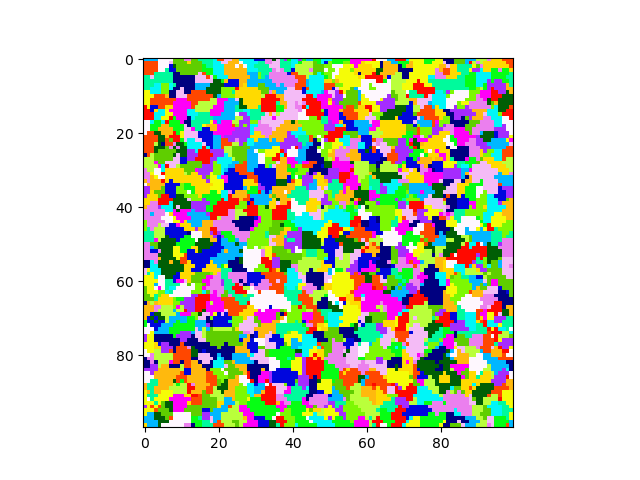

In [12]:
cpm = CellularPottsModel(L=100, n_cells=20, lattice_type=None, T=10, adhessions=J, C_p=0)

cpm.save_animation(steps_per_frame=500, frames=100, prerun=True)

In [ ]:
A = np.zeros((5,5))
A[0:2, 1] = 1
A[2:4, 2:4] = 3

A

array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 3., 3., 0.],
       [0., 0., 3., 3., 0.],
       [0., 0., 0., 0., 0.]])